# Convert nldas soil data to new netcdf file to work with intersectR.  Goal to write file as a standard cf-compliant netCDF file based on original data.

In [27]:
"""Example notebook to work with nldas soil moisture netcdf files."""

import geopandas as gpd
import numpy as np
import time
import xagg as xa
import pickle
import xarray as xr
import cftime
import datetime
from datetime import timedelta
import rioxarray
import pandas as pd

In [110]:
ds = xr.open_dataset('../data/bas_ref_all/noan_sm_d_1981.nc')
# this netCDF file contains lat/lon in the attributes.  xagg and indeed cf-standards require lat lon variables os here we add them
ds['lon'] = ds.attrs['Lon']
ds['lat'] = ds.attrs['Lat']
gdf = gpd.read_file('../data/bas_ref_all/bas_ref_all.shp')
gdf.to_crs('epsg:4386', inplace=True)

In [111]:
gdf

,AREA,PERIMETER,GAGE_ID,STAID,geometry
0,2.252690e+09,516060.0,01013500,1013500.0,"POLYGON ((-68.71709 47.17016, -68.71698 47.170..."
1,1.003230e+07,18600.0,01017550,1017550.0,"POLYGON ((-67.95766 46.62456, -67.95803 46.624..."
2,1.610010e+07,27660.0,01021470,1021470.0,"POLYGON ((-67.72204 44.77132, -67.72215 44.771..."
3,7.673850e+07,67980.0,01021480,1021480.0,"POLYGON ((-67.84718 45.04170, -67.84755 45.041..."
4,1.619920e+08,126240.0,01022260,1022260.0,"POLYGON ((-67.79280 44.68640, -67.79244 44.686..."
...,...,...,...,...,...
2052,7.939520e+08,218220.0,06280300,6280300.0,"POLYGON ((-109.85410 43.92525, -109.85447 43.9..."
2053,1.629860e+08,92400.0,06632400,6632400.0,"POLYGON ((-106.26624 41.55221, -106.26660 41.5..."
2054,3.983090e+08,166380.0,09210500,9210500.0,"POLYGON ((-110.61114 42.38294, -110.61078 42.3..."
2055,7.164230e+08,156740.0,10308200,10308200.0,"POLYGON ((-119.90409 38.70734, -119.90412 38.7..."


In [112]:
ds

<xarray.Dataset>
Dimensions:          (lat: 224, lon: 464, JD: 365)
Coordinates:
  * lon              (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat              (lat) float64 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
Dimensions without coordinates: JD
Data variables:
    SoilM_0_10cm     (lat, lon, JD) float64 ...
    SoilM_10_40cm    (lat, lon, JD) float64 ...
    SoilM_40_100cm   (lat, lon, JD) float64 ...
    SoilM_100_200cm  (lat, lon, JD) float64 ...
Attributes:
    creation_date:  16-Jul-2021 10:26:34
    Lon:            [-124.9375 -124.8125 -124.6875 -124.5625 -124.4375 -124.3...
    Lat:            [25.0625 25.1875 25.3125 25.4375 25.5625 25.6875 25.8125 ...

In [113]:
start = datetime.datetime(1981, 1, 1)
times = np.array([start + timedelta(days=d) for d in range(365)])
simple_times = np.arange(365)
time_units = 'days since {:%Y-%m-%d 00:00}'.format(times[0])
time_vals = cftime.date2num(times, time_units, calendar='standard', has_year_zero=None)
dates = pd.date_range(start='1981-01-01 12:00', end='1981-12-31 12:00', freq='1d') # better method of generating dates per Signells help to MW
SoilM_0_10cm = ds['SoilM_0_10cm'].transpose('JD', 'lat', 'lon').values
SoilM_10_40cm = ds['SoilM_10_40cm'].transpose('JD', 'lat', 'lon').values
SoilM_40_100cm = ds['SoilM_40_100cm'].transpose('JD', 'lat', 'lon').values
SoilM_100_200cm = ds['SoilM_100_200cm'].transpose('JD', 'lat', 'lon').values

ds_new = xr.Dataset({'SoilM_0_10cm': (['time', 'lat', 'lon'], SoilM_0_10cm, {'units': 'percent'}),
                    'SoilM_10_40cm': (['time', 'lat', 'lon'], SoilM_10_40cm, {'units': 'percent'}),
                    'SoilM_40_100cm': (['time', 'lat', 'lon'], SoilM_40_100cm, {'units': 'percent'}),
                    'SoilM_100_200cm': (['time', 'lat', 'lon'], SoilM_100_200cm, {'units': 'percent'})},
                    coords={'lat': (['lat'], ds['lat'].values, {'units':'degrees_north'}), 
                            'lon': (['lon'], ds['lon'].values, {'units':'degrees_east'}), 
                            'time': (['time'], dates)})
ds_new.time.encoding['units'] = time_units

In [114]:
ds_new = ds_new.rio.write_crs('epsg:4326')

In [115]:
ds_new

<xarray.Dataset>
Dimensions:          (time: 365, lat: 224, lon: 464)
Coordinates:
  * lat              (lat) float64 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * lon              (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * time             (time) datetime64[ns] 1981-01-01T12:00:00 ... 1981-12-31...
    spatial_ref      int64 0
Data variables:
    SoilM_0_10cm     (time, lat, lon) float64 nan nan nan ... 38.94 39.01 37.74
    SoilM_10_40cm    (time, lat, lon) float64 nan nan nan ... 83.27 83.29 81.53
    SoilM_40_100cm   (time, lat, lon) float64 nan nan nan ... 141.6 141.7 140.3
    SoilM_100_200cm  (time, lat, lon) float64 nan nan nan ... 215.7 215.8 215.6

In [116]:
# ds_new.to_netcdf('testd.nc')

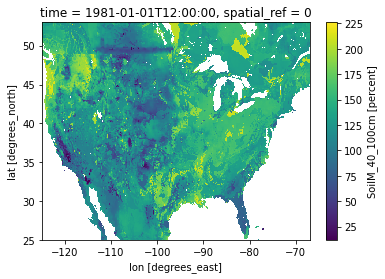

In [117]:
ds_new.SoilM_40_100cm.sel(time='1981-01-01').plot(x='lon', y='lat')

## Add CF Attributes according to NASA Dataset Interoperability Recommendations
* https://unidata.github.io/python-training/workshop/XArray/xarray-and-cf/


In [118]:
#https://pyproj4.github.io/pyproj/stable/build_crs_cf.html#exporting-crs-to-cf
# link above provides some nice tools for getting proj information.
from pyproj import CRS
crs = CRS("epsg:4326")
cf_grid_mapping = crs.to_cf()
cf_coordinate_system = crs.cs_to_cf()
print(cf_coordinate_system[0]['axis'])
print(cf_grid_mapping)
crs

Y
{'crs_wkt': 'GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]', 'semi_major_axis': 6378137.0, 'semi_minor_axis': 6356752.314245179, 'inverse_flattening': 298.257223563, 'reference_ellipsoid_name': 'WGS 84', 'longitude_of_prime_meridian': 0.0, 'prime_meridian_name': 'Greenwich', 'geographic_crs_name': 'WGS 84', 'grid_mapping_name': 'latitude_longitude'}


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [119]:
crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [120]:
cf_grid_mapping

{'crs_wkt': 'GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],CS[ellipsoidal,2],AXIS["geodetic latitude (Lat)",north,ORDER[1],ANGLEUNIT["degree",0.0174532925199433]],AXIS["geodetic longitude (Lon)",east,ORDER[2],ANGLEUNIT["degree",0.0174532925199433]],USAGE[SCOPE["Horizontal component of 3D system."],AREA["World."],BBOX[-90,-180,90,180]],ID["EPSG",4326]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'grid_mapping_name': 'latitude_longitude'}

In [121]:
# https://pyproj4.github.io/pyproj/stable/build_crs_cf.html#exporting-crs-to-cf
from pyproj import CRS
crs = CRS("epsg:4326")
cf_grid_mapping = crs.to_cf()
cf_coordinate_system = crs.cs_to_cf()
cf_coordinate_system[0]['axis']
     
ds_new.lat.attrs['axis'] = cf_coordinate_system[0]['axis']
ds_new.lat.attrs['standard_name'] = cf_coordinate_system[0]['standard_name']
ds_new.lat.attrs['long_name'] = cf_coordinate_system[0]['long_name']
ds_new.lat.attrs['units'] = cf_coordinate_system[0]['units']

ds_new.lon.attrs['axis'] = cf_coordinate_system[1]['axis']
ds_new.lon.attrs['standard_name'] = cf_coordinate_system[1]['standard_name']
ds_new.lon.attrs['long_name'] = cf_coordinate_system[1]['long_name']
ds_new.lon.attrs['units'] = cf_coordinate_system[1]['units']

ds_new.SoilM_0_10cm.attrs['grid_mapping'] = 'spatial_ref'
ds_new.SoilM_10_40cm.attrs['grid_mapping'] = 'spatial_ref'
ds_new.SoilM_40_100cm.attrs['grid_mapping'] = 'spatial_ref'
ds_new.SoilM_100_200cm.attrs['grid_mapping'] = 'spatial_ref'

# ds_new['latitude_longitude'] = int()
# ds_new.latitude_longitude.attrs['grid_mapping_name'] = 'latitude_longitude'
# ds_new.latitude_longitude.attrs['semi_major_axis'] = cf_grid_mapping['semi_major_axis']
# ds_new.latitude_longitude.attrs['semi_minor_axis'] = cf_grid_mapping['semi_minor_axis']
# ds_new.latitude_longitude.attrs['inverse_flattening'] = cf_grid_mapping['inverse_flattening']
# ds_new.latitude_longitude.attrs['prime_meridian_name'] = cf_grid_mapping['prime_meridian_name']
# ds_new.latitude_longitude.attrs['epsg_code'] = 'EPGS:4326'
# ds_new.longitude_latitude.attrs['semi_major_axis'] = cf_grid_mapping['ID']

In [122]:
ds_new



<xarray.Dataset>
Dimensions:          (time: 365, lat: 224, lon: 464)
Coordinates:
  * lat              (lat) float64 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * lon              (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * time             (time) datetime64[ns] 1981-01-01T12:00:00 ... 1981-12-31...
    spatial_ref      int64 0
Data variables:
    SoilM_0_10cm     (time, lat, lon) float64 nan nan nan ... 38.94 39.01 37.74
    SoilM_10_40cm    (time, lat, lon) float64 nan nan nan ... 83.27 83.29 81.53
    SoilM_40_100cm   (time, lat, lon) float64 nan nan nan ... 141.6 141.7 140.3
    SoilM_100_200cm  (time, lat, lon) float64 nan nan nan ... 215.7 215.8 215.6

In [123]:
ds_new.to_netcdf('test2d.nc')

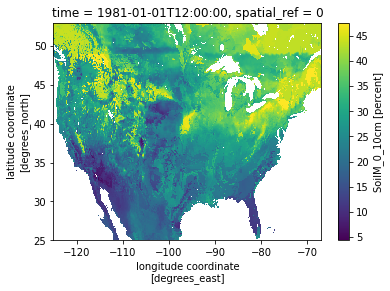

In [109]:
ds_new.SoilM_0_10cm.sel(time='1981-01-01').plot(x='lon', y='lat')

# Rich Signells version
Rich did everything in-place (much better) whereas I extracted the data and rewrote the file.
* Problems to fix
** the longitude and latitude values are in global attributes instead of variables
** there is no time coordinate
** no attribute information for variables

In [88]:
ds2 = xr.open_dataset('../data/bas_ref_all/noan_sm_d_1981.nc')
# this netCDF file contains lat/lon in the attributes.  xagg and indeed cf-standards require lat lon variables os here we add them
ds2['lon'] = ds2.attrs['Lon']
ds2['lat'] = ds2.attrs['Lat']

attrs = ds2.attrs
del attrs['Lon']
del attrs['Lat']

ds2 = ds2.assign_attrs(attrs)

In [89]:
dates = pd.date_range(start='1981-01-01 12:00',end='1981-12-31 12:00', freq='1d')
ds2['time'] = dates
ds2 = ds2.swap_dims({'time':'JD'})
ds2 = ds2.rename({'JD':'time'})

In [90]:
ds2['lon'] = ds2['lon'].assign_attrs({'standard_name':'longitude', 'units':'degrees_east'})
ds2['lat'] = ds2['lat'].assign_attrs({'standard_name':'latitude', 'units':'degrees_north'})

In [91]:
ds2

<xarray.Dataset>
Dimensions:          (lat: 224, lon: 464, time: 365)
Coordinates:
  * lon              (lon) float64 -124.9 -124.8 -124.7 ... -67.31 -67.19 -67.06
  * lat              (lat) float64 25.06 25.19 25.31 25.44 ... 52.69 52.81 52.94
  * time             (time) datetime64[ns] 1981-01-01T12:00:00 ... 1981-12-31...
Data variables:
    SoilM_0_10cm     (lat, lon, time) float64 ...
    SoilM_10_40cm    (lat, lon, time) float64 ...
    SoilM_40_100cm   (lat, lon, time) float64 ...
    SoilM_100_200cm  (lat, lon, time) float64 ...
Attributes:
    creation_date:  16-Jul-2021 10:26:34

In [92]:
ds2.to_netcdf('test3a.nc')

# RMCD adding mapping variable - because (I think) it's standard.

In [24]:
ds2['crs'] = int()
ds2.crs.attrs['grid_mapping_name'] = 'latitude_longitude'
ds2.crs.attrs['semi_major_axis'] = cf_grid_mapping['semi_major_axis']
ds2.crs.attrs['semi_minor_axis'] = cf_grid_mapping['semi_minor_axis']
ds2.crs.attrs['inverse_flattening'] = cf_grid_mapping['inverse_flattening']
ds2.crs.attrs['prime_meridian_name'] = cf_grid_mapping['prime_meridian_name']
ds2.crs.attrs['epsg_code'] = 'EPGS:4326'

In [25]:
ds2.SoilM_0_10cm.attrs['grid_mapping'] = 'crs'
ds2.SoilM_10_40cm.attrs['grid_mapping'] = 'crs'
ds2.SoilM_40_100cm.attrs['grid_mapping'] = 'crs'
ds2.SoilM_100_200cm.attrs['grid_mapping'] = 'crs'


In [26]:
ds2.to_netcdf('test_inplace.nc')